# Attribute

**Original Work**: *Maziar Raissi, Paris Perdikaris, and George Em Karniadakis*

**Github Repo** : https://github.com/maziarraissi/PINNs

**Link:** https://github.com/maziarraissi/PINNs/tree/master/appendix/continuous_time_identification%20(Burgers)

@article{raissi2017physicsI,
  title={Physics Informed Deep Learning (Part I): Data-driven Solutions of Nonlinear Partial Differential Equations},
  author={Raissi, Maziar and Perdikaris, Paris and Karniadakis, George Em},
  journal={arXiv preprint arXiv:1711.10561},
  year={2017}
}

@article{raissi2017physicsII,
  title={Physics Informed Deep Learning (Part II): Data-driven Discovery of Nonlinear Partial Differential Equations},
  author={Raissi, Maziar and Perdikaris, Paris and Karniadakis, George Em},
  journal={arXiv preprint arXiv:1711.10566},
  year={2017}
}

## Libraries and Dependencies

In [1]:
#下面这行代码，是为了把自己编写的代码文件当作一共模块导入，这里是把Utilities文件夹中的plotting.py文件当作python的模块导入，对应的是下面的from plotting import newfig, savefig。路径要随着不同设备的系统做相应的修改
import sys #导入sys模块。sys模块提供了一些变量和函数，用于与 Python解释器进行交互和访问。例如，sys.path 是一个 Python 在导入模块时会查找的路径列表，sys.argv 是一个包含命令行参数的列表，sys.exit() 函数可以用于退出 Python 程序。导入 sys 模块后，你就可以在你的程序中使用这些变量和函数了。
sys.path.insert(0, 'C:/Users/cheny/Documents/GitHub/PINNs/Utilities/')  #在 Python的sys.path列表中插入一个新的路径。sys.path是一个 Python 在导入模块时会查找的路径列表。新的路径'../../Utilities/'相对于当前脚本的路径。当你尝试导入一个模块时，Python 会在 sys.path 列表中的路径下查找这个模块。通过在列表开始位置插入一个路径，你可以让 Python 优先在这个路径下查找模块。这在你需要导入自定义模块或者不在 Python 标准库中的模块时非常有用。

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
#下面的`scipy`是一个用于科学计算和技术计算的Python库，提供了许多高级的数学函数和便利的操作，包括数值积分、插值、优化、图像处理、统计等。
import scipy.io #导入了scipy库中的io模块。scipy.io模块包含了一些用于文件输入/输出的函数，例如读取和写入.mat文件（MATLAB格式）。
from scipy.interpolate import griddata #`scipy.interpolate`是`scipy`库中的一个模块，提供了许多插值工具，用于在给定的离散数据点之间进行插值和拟合。`griddata`是这个模块中的一个函数，用于在无规则的数据点上进行插值。
from pyDOE import lhs #`pyDOE`是一个Python库，用于设计实验。它提供了一些函数来生成各种设计，如因子设计、拉丁超立方设计等。`lhs`是库中的一个函数，全名为"Latin Hypercube Sampling"，拉丁超立方采样。这是一种统计方法，用于生成一个近似均匀分布的多维样本点集。它在参数空间中生成一个非常均匀的样本，这对于高维数值优化问题非常有用，因为它可以更好地覆盖参数空间。
from plotting import newfig, savefig  #从自定义的plotting.py文件中导入了newfig和savefig函数。这两个函数用于创建和保存图形。这两个函数的定义在plotting.py文件中
from mpl_toolkits.mplot3d import Axes3D #`mpl_toolkits.mplot3d`是`matplotlib`库的一个模块，用于创建三维图形。`Axes3D`是`mpl_toolkits.mplot3d`模块中的一个类，用于创建一个三维的坐标轴。可以在这个坐标轴上绘制三维的图形，如曲线、曲面等。
import time #一个内置模块，用于处理时间相关的操作。
import matplotlib.gridspec as gridspec #是`matplotlib`库的一个模块，用于创建一个网格布局来放置子图。在`matplotlib`中可以创建一个或多个子图（subplot），每个子图都有自己的坐标轴，并可以在其中绘制图形。`gridspec`模块提供了一个灵活的方式来创建和放置子图。
from mpl_toolkits.axes_grid1 import make_axes_locatable #`mpl_toolkits.axes_grid1`是`matplotlib`库的一个模块，提供了一些高级的工具来控制matplotlib图形中的坐标轴和颜色条。`make_axes_locatable`是模块中的一个函数，用于创建一个可分割的坐标轴。可以在这个坐标轴的四个方向（上、下、左、右）添加新的坐标轴或颜色条。

#NumPy和TensorFlow都有自己的随机数生成器，它们是独立的，互不影响。也就是说，设置NumPy的随机数种子不会影响TensorFlow的随机数生成，反之亦然
np.random.seed(1234) #设置了NumPy的随机数生成器的种子。设置随机数生成器的种子可以确保每次运行程序时，NumPy生成的随机数序列都是一样的。
tf.set_random_seed(1234) #设置了TensorFlow的随机数生成器的种子。设置随机数生成器的种子可以确保每次运行程序时，TensorFlow生成的随机数序列都是一样的


## Physics-informed Neural Networks

In [1]:
class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, X_u, u, X_f, layers, lb, ub, nu): #这个类包含的第一个方法__init__，这是一个特殊的方法，也就是这个类的构造函数，用于初始化新创建的对象，接受了几个参数
        
        #Python使用self关键字来表示类的实例。当在类的方法中定义一个变量时，例如lb和ub，这些变量只在该方法内部可见，也就是说它们的作用域仅限于该方法。当方法执行完毕后，这些变量就会被销毁，无法在其他方法中访问它们。但如果希望在类的其他方法中也能访问这些变量就需要将它们保存为类的实例属性。这就是self.lb和self.ub的作用。
            #通过将lb和ub赋值给self.lb和self.ub，就可以在类的其他方法中通过self.lb和self.ub来访问这些值。总的来说，self.lb和self.ub是类的实例属性，它们的作用域是整个类，而不仅仅是定义它们的方法。
        self.lb = lb  #将传入的lb和ub参数的值存储在实例中，以便后续使用。这样可以在类的其他方法中通过self.lb和self.ub来访问这些值。
        self.ub = ub
    
        self.x_u = X_u[:,0:1] #将X_u的第一列赋值给self.x_u，将X_u的第二列赋值给self.t_u。
        self.t_u = X_u[:,1:2]
        
        self.x_f = X_f[:,0:1] #将X_f的第一列赋值给self.x_f，将X_f的第二列赋值给self.t_f。
        self.t_f = X_f[:,1:2]
        
        self.u = u
        
        self.layers = layers #将传入的layers参数的值存储在实例中，以便后续使用。这样可以在类的其他方法中通过self.layers来访问这些值。
        self.nu = nu
        
        # Initialize NNs
        self.weights, self.biases = self.initialize_NN(layers) #调用了initialize_NN方法，用于初始化神经网络的权重和偏置。这个方法接受一个参数layers，它是一个列表，包含了神经网络的层数和每一层的神经元数量。例如，layers=[2, 100, 100, 100, 100, 2]表示神经网络有5个隐藏层，每个隐藏层有100个神经元，输入层和输出层分别有2个神经元。这个方法返回了神经网络的权重和偏置（具体见下面），分别存储在self.weights和self.biases中。
        
        # tf placeholders and graphxia

        #使用tf.Session创建了一个名为tf.sess的会话。接受一个config参数，这是一个tf.ConfigProto对象，用于设置会话的配置选项。这里设置了两个选项：
              #allow_soft_placement：如果设置为True，那么当某些操作无法在GPU上执行时，TensorFlow会自动将它们放在CPU上执行；
              #log_device_placement：如果设置为True，那么在日志中会记录每个节点被安排在哪个设备上执行
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        #使用TensorFlow库创建占位符，用于存储输入和输出数据。占位符是TensorFlow中的一个特殊对象，允许在运行时将数据传递给TensorFlow计算图。可以将占位符看作是一个变量，但不需要提供初始值。相反只需要在运行计算图时提供一个值。使用feed_dict参数来为占位符提供值。
            #例如，如果x是一个占位符，可以使用feed_dict={x: 1.0}来为它提供值。这个值可以是一个单独的数字，也可以是一个数组。        
        #每个占位符都使用了tf.placeholder函数进行创建。该函数接受两个参数,第一个是数据类型,这里都是tf.float32,表示占位符的数据类型是浮点数。第二个参数是形状,这里都是[None,self.x0.shape[1]]这样的形式，其中None表示这一维的长度可以是任意的，self.x0.shape[1]表示这一维的长度是self.x0的列数。
        self.x_u_tf = tf.placeholder(tf.float32, shape=[None, self.x_u.shape[1]])
        self.t_u_tf = tf.placeholder(tf.float32, shape=[None, self.t_u.shape[1]])        
        self.u_tf = tf.placeholder(tf.float32, shape=[None, self.u.shape[1]])
        
        self.x_f_tf = tf.placeholder(tf.float32, shape=[None, self.x_f.shape[1]])
        self.t_f_tf = tf.placeholder(tf.float32, shape=[None, self.t_f.shape[1]])        

        # tf Graphs，这里是使用TensorFlow库进行神经网络前向传播的部分（预测部分）。        
        self.u_pred = self.net_u(self.x_u_tf, self.t_u_tf) #是调用net_u函数,将self.x_u_tf和self.t_u_tf作为参数传入,然后将返回的结果赋值给self.u_pred
        self.f_pred = self.net_f(self.x_f_tf, self.t_f_tf) #是调用net_f函数,将self.x_f_tf和self.t_f_tf作为参数传入,然后将返回的结果赋值给self.f_pred


        # Loss，这里是使用TensorFlow库计算损失函数的部分，训练目标是最小化损失函数，这里的损失函数由两部分组成，分别是初始条件、边界条件、微分方程两边的残差。每一部分都是预测值与真实值之间的差的平方的均值（均方误差）
        #tf.reduce_mean是TensorFlow库中的一个函数，用于计算张量的均值。它接受一个参数，即张量，可以是一个一维数组，也可以是一个多维数组。它会返回一个标量，即这个张量的均值。
        #tf.square是TensorFlow库中的一个函数，用于计算张量的平方。它接受一个参数，即张量，可以是一个一维数组，也可以是一个多维数组。它会返回一个与输入张量形状相同的张量，其中每个元素都是输入张量对应元素的平方。
        #这里的+ \表示将两行代码连接成一行，这是Python中的行连接符，用于将一行代码分成多行书写。
        self.loss = tf.reduce_mean(tf.square(self.u_tf - self.u_pred)) + \
                    tf.reduce_mean(tf.square(self.f_pred))
               

        # Optimizers，这里是使用TensorFlow库进行优化的部分，使用L-BFGS-B。L-BFGS-B是一种基于梯度的优化方法，它使用了拟牛顿法来寻找损失函数的最小值。
        #首先用tf.contrib.opt.ScipyOptimizerInterface函数创建了一个优化器self.optimizer，它使用了L-BFGS-B方法，最大迭代次数为50000次，最大函数调用次数为50000次，最大相关矩阵大小为50，最大线搜索次数为50，终止条件为1.0 * np.finfo(float).eps。
              #tf.contrib.opt.ScipyOptimizerInterface是TensorFlow中的函数，提供了一个接口，可以使用优化算法来最小化TensorFlow的损失函数，接受三个参数，第一个参数是损失函数（这里是self.loss）,第二个参数是优化方法，这里是L-BFGS-B，第三个参数options是一个字典，用于指定优化器的参数。
              #这里maxiter表示最大迭代次数，maxfun表示最大函数调用次数，maxcor表示每次迭代中使用的最大修正因子数量，maxls表示每次迭代中最大线搜索次数，ftol表示终止条件，这里是1.0*np.finfo(float).eps，其中np.finfo(float).eps表示浮点数的精度，1.0 * np.finfo(float).eps表示浮点数的精度乘以1.0。
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 50000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})
        
        #使用tf.global_variables_initializer函数创建了一个初始化所有全局变量的操作（Tensorflow中所有变量在使用之前都需要进行初始化）
        init = tf.global_variables_initializer()
        #sess.run是会话的一个方法，用于执行图中的操作或计算张量的值。这里是执行初始化
        self.sess.run(init)

        #新加的东西，用来记录迭代次数
        self.iter = 0

                
    #定义了一个名为`initialize_NN'的函数/方法，用于初始化神经网络的权重和偏置，最后返回权重和偏置。                 
    def initialize_NN(self, layers):  #接受一个参数layers
        #定义了两个空列表weights和biases，用于存储神经网络的权重和偏置      
        weights = []
        biases = []
        num_layers = len(layers) #获取神经网络的层数（由输入参数给出）并将其赋值给num_layers
        for l in range(0,num_layers-1): #使用循环遍历神经网络的每一层（除了输出层）
            W = self.xavier_init(size=[layers[l], layers[l+1]]) #初始化该层的权重，使用了xavier_init函数(该函数定义在下面)进行Xaiver初始化，权重的形状是layers[l]*layers[l+1]，其中layers[l]是上一层的神经元数量，layers[l+1]是当前层的神经元数量。
              #tf.Variable(initial_value, dtype=None, name=None)函数用于创建一个变量，接受三个参数，第一个参数initial_value是变量的初始值，第二个参数dtype是变量的数据类型，第三个参数name是变量的名称。
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32) #初始化该层的偏置b，使用了tf.Variable函数，将偏置b初始化为一个形状为[1,layers[l+1]]的全0数组，其中layers[l+1]是当前层的神经元数量
              #list.append(element)是Python中的一个方法，用于向列表中添加元素（添加到列表末尾）。list是要添加元素的列表，element是要添加的元素（然和类型的参数均可）。
            weights.append(W) #将初始化的权重和偏置添加到weights和biases列表中
            biases.append(b)        
        return weights, biases
        

    #定义了一个名为xavier_init的函数/方法，用于初始化神经网络的权重(在神经网络参数初始化中实现，见上面)。这个函数使用了Xavier初始化方法，这是一种常用的权重初始化方法，可以帮助我们在训练深度神经网络时保持每一层的激活值的分布相对稳定。    
    def xavier_init(self, size): #接受一个参数size，这是一个列表，包含了权重的形状
        in_dim = size[0] #输入维度是size的第一个数
        out_dim = size[1]   #输出维度是size的第二个数     
        xavier_stddev = np.sqrt(2/(in_dim + out_dim)) #计算标准差
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32) #返回一个变量，类型为32位浮点，初始值为截断正态分布，标准差为xavier_stddev，形状为[in_dim, out_dim]，其中in_dim和out_dim分别是输入维度和输出维度
    
    #定义了一个名为neural_net的函数/方法，用于实现神经网络的输出。这个方法接受三个参数，分别是X，weights和biases，其中X是输入数据，weights和biases是神经网络的权重和偏置。
    def neural_net(self,X,weights,biases):
        num_layers=len(weights)+1 #计算神经网络的层数并返回到num_layers，其值位权重矩阵的长度（行数）加1
        
        H=2.0*(X-self.lb)/(self.ub-self.lb)-1.0 #这里H是X经过归一化处理后的结果，将X映射到了[-1,1]区间内
        for l in range(0,num_layers-2): #使用循环遍历神经网络的每一层（除了输出层）
            W=weights[l] #获取当前层的权重
            b=biases[l] #获取当前层的偏置
            H=tf.tanh(tf.add(tf.matmul(H,W),b)) #计算当前层的输出，使用了tf.matmul函数计算矩阵乘法，tf.add函数计算矩阵加法，tf.tanh函数计算双曲正切函数
        W=weights[-1] #获取输出层的权重,这里的weights[-1]表示列表weights的最后一个元素
        b=biases[-1] #获取输出层的偏置
        Y=tf.add(tf.matmul(H,W),b)  #计算输出层的输出H*W+b
        return Y #返回输出层的输出Y
    

    #定义了一个名为net_u的函数/方法，用于计算神经网络的输出。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回神经网络的输出。        
    def net_u(self, x, t):
        u = self.neural_net(tf.concat([x,t],1), self.weights, self.biases)  #（第一个参数将输入的两个参数x和t在第二个维度（列）上进行拼接，形成一个新的张量）调用之前定义的neural_net函数，根据两个参数权重和偏置，以及新得到的张量，计算神经网络的输出u
        return u
    

    #定义了一个名为net_f的函数/方法，用于计算论文中的f。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回计算得到的f。
    def net_f(self, x,t):
        u = self.net_u(x,t) #调用上面的net_u函数，计算神经网络的输出u
        u_t = tf.gradients(u, t)[0] #计算u关于t的梯度，也就是u关于t的导数
        u_x = tf.gradients(u, x)[0] #计算u关于x的梯度，也就是u关于x的导数
        u_xx = tf.gradients(u_x, x)[0] #计算u关于x的二阶梯度，也就是u关于x的二阶导数
        f = u_t + u*u_x - self.nu*u_xx #计算f，定义见论文
        
        return f
    
    def callback(self, loss): #定义了一个名为callback的函数/方法，打印损失值并记录迭代次数
        self.iter += 1 #更新迭代次数
        if self.iter % 100 == 0: #每一百次打印迭代次数及损失
            print(
                'Iter %d, Loss: %e' % (self.iter, loss)
            )

    #定义了一个名为train的函数/方法，用于训练神经网络。但这个方法不接受任何参数（如迭代次数nIter）。    
    def train(self):
         #创建一个名为tf_dict的字典，该字典将TensorFlow占位符映射到它们对应的数据。创建tf_dict的目的是为了在运行TensorFlow的计算图时，能够将数据传递给占位符。例如，当运行self.sess.run(self.train_op_Adam, tf_dict)时，tf_dict中的数据就会被传递给对应的占位符，然后在计算图中使用
            #字典语法：dict = {key1: value1, key2: value2, ...}：key1、key2等是字典的键，value1、value2等是对应的值（这里键是占位符，值是对应的数据）。
        tf_dict = {self.x_u_tf: self.x_u, self.t_u_tf: self.t_u, self.u_tf: self.u,
                   self.x_f_tf: self.x_f, self.t_f_tf: self.t_f}

         #使用优化器来最小化损失函数，第一个参数表示TensorFlow会话，第二个参数表示将数据传递给占位符的字典，fetches表示要获取的结果（这里只获取了损失函数的值），最后一个参数表示每次优化迭代后调用的回调参数，这里是之前定义的，用来打印损失函数                                                                                                                  
        self.optimizer.minimize(self.sess, 
                                feed_dict = tf_dict,         
                                fetches = [self.loss], 
                                loss_callback = self.callback)        
                                    
    #定义了一个名为predict的函数/方法，用于预测神经网络的输出。这个方法接受一个参数X_star，表示输入数据。最后返回预测的两个输出。
    def predict(self, X_star):
        #括号内第二个参数是创建一个字典，其中包含了两个键值对，键是 TensorFlow 的占位符（self.x_u_tf和self.t_u_tf），值是X_star中的对应列。这个字典将被用于在下面的TensorFlow 会话中给placeholder赋值，用以运行计算图
        #使用 self.sess.run方法来给placeholder赋值并运行计算图，获取self.u_pred(神经网络的输出)的计算结果。并将结果保存在u_star中        
        u_star = self.sess.run(self.u_pred, {self.x_u_tf: X_star[:,0:1], self.t_u_tf: X_star[:,1:2]})  
        #括号内第二个参数是创建一个字典，其中包含了两个键值对，键是 TensorFlow 的占位符（self.x_f_tf和self.t_f_tf），值是X_star中的对应列。这个字典将被用于在下面的TensorFlow 会话中给placeholder赋值，用以运行计算图
        #使用 self.sess.run方法来给placeholder赋值并运行计算图，获取self.f_pred(神经网络的输出)的计算结果。并将结果保存在f_star中
        f_star = self.sess.run(self.f_pred, {self.x_f_tf: X_star[:,0:1], self.t_f_tf: X_star[:,1:2]})
        return u_star, f_star

## Configurations

In [ ]:
#Python中的一个常见模式。在Python文件被直接运行时，特殊变量__name__的值为"__main__"。所以，这行代码的意思是：如果这个文件被直接运行（而不是被导入作为模块），那么就执行后面的代码
if __name__ == "__main__":   #这种模式常常用于在一个Python文件中区分出哪些代码是用于定义函数、类等，哪些代码是用于直接执行的。这样，当这个文件被导入作为模块时，只有函数和类的定义会被执行，而直接执行的代码则不会被执行
     
    nu = 0.01/np.pi
    #设置噪声水平为0
    noise = 0.0        

    N_u = 100
    N_f = 10000
    #定义一个列表layers，其中包含了神经网络的层数和每一层的神经元数量
    layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]
    #读取名为burgers_shock的Matlab文件，文件中的数据存储在data变量中。这里的路径也要随着设备的情况修改 
    data = scipy.io.loadmat('C:/Users/cheny/Documents/GitHub/PINNs/appendix/Data/burgers_shock.mat')
    #从data字典中取出变量tt和x的值，并转换为一维数组（flatten方法），最后tongg[:,None]将一维数组转换为二维数组
    t = data['t'].flatten()[:,None]
    x = data['x'].flatten()[:,None]
    Exact = np.real(data['usol']).T #从data数据中取出usol的值，并取实部，最后转置，赋值给Exact
    #生成一个二位网络，X和T是输出的二维数组
    #这个点结果是X和T均为形状为[len(t),len(x)]的二维数组，X的每一行都是x，一共len(t)行，T的每一列都是t，一共len(x)列
    X, T = np.meshgrid(x,t)
    
    X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))  #按列堆叠数组，X_star是一个二维数组，其中第一列是X的展平，第二列是T的展平
    u_star = Exact.flatten()[:,None]    #对Exact_u使用flatten方法将其转换为一维数组，最后使用[:,None]将其转换为二维数组         

    # Doman bounds，分别获得X_star的相应列上的最小值和最大值，赋值给lb和ub,也就是说lb是x和t的最小值，ub是x和t的最大值，即lb和ub分别为[-1,0]和[1,1]
    lb = X_star.min(0)
    ub = X_star.max(0)    


    #生成初值和边界值的训练基础数据
    xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T)) #分别取X，T的第一行的转置(分别是x和全0列)，分别构成xx1的第一列和第二列
    uu1 = Exact[0:1,:].T #取Exact的第一行的转置，赋值给uu1
    xx2 = np.hstack((X[:,0:1], T[:,0:1])) #分别取X，T的第一列(分别是全-1列和t)，分别构成xx2的第一列和第二列
    uu2 = Exact[:,0:1] #取Exact的第一列，赋值给uu2
    xx3 = np.hstack((X[:,-1:], T[:,-1:])) #分别取X，T的最后一列(分别是全1列和t)，分别构成xx3的第一列和第二列
    uu3 = Exact[:,-1:] #取Exact的最后一列，赋值给uu3
    
    X_u_train = np.vstack([xx1, xx2, xx3]) #X_u_train=(xx1;xx2;xx3)
    #生成配位点训练基础数据
    X_f_train = lb + (ub-lb)*lhs(2, N_f)  #lhs函数采用拉丁超采样方法，生成一个近似均匀分布的多维样本点集，表示生产的样本有两个特征，共N_f个样本数量，所以返回的是一个形状为（N_f，2）的数组，每一行都是一个2维的样本点，所有样本点都在[0,1]范围内，并对该样本集进行缩放，把每个样本从[0,1]区间缩放到[lb,ub]区域内，即得到了指定范围内均匀分布的样本X_f_train。
    
    X_f_train = np.vstack((X_f_train, X_u_train)) #按行堆叠数组，即将X_f_train和X_u_train按行合并，得到一个新的数组X_f_train

    u_train = np.vstack([uu1, uu2, uu3]) #u_train=(uu1;uu2;uu3)
    
    #从所有的初值边界值训练基础数据中选取N_u=100个点
    idx = np.random.choice(X_u_train.shape[0], N_u, replace=False) #从0~数组X_u_train的行数 中随机选择N_u个数，replace=False表示不允许重复选择，最后将这N_u个数赋值给idx
    X_u_train = X_u_train[idx, :] #从X_u_train中选取idx对应的的N_u行，赋值给X_u_train
    u_train = u_train[idx,:] #从u_train中选取idx对应的的N_u行，赋值给u_train


## Training

In [4]:
#创建PINN模型并输入各种参数     
model = PhysicsInformedNN(X_u_train, u_train, X_f_train, layers, lb, ub, nu)

#获取当前时间并赋值给start_time  
start_time = time.time()   
#开始训练模型            
model.train()
#训练结束后获取当前时间并减去start_time，得到训练时间并赋值给elapsed
elapsed = time.time() - start_time
#打印训练所花时间                
print('Training time: %.4f' % (elapsed))

#用训练好的模型调用predict方法进行预测，返回两个值（均为数组）
u_pred, f_pred = model.predict(X_star)
#计算误差（基于2范数）        
error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
#打印误差值
print('Error u: %e' % (error_u))                     



#使用griddata函数将X_star、u_pred插值到网格上，得到U_pred
U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
#计算插值方法的误差
Error = np.abs(Exact - U_pred)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:1 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:2 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:3 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:4 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:5 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:6 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:7 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: TITAN RTX, pci bus id: 0000:1a:00.0, compute capability: 7.5
/job:localhost/replica:0/task:0/device:GPU:1 -> device: 1, name: TITAN RTX, pci bus id: 0000:1b:00.0, compute capability: 7.5
/job:localhost/replica:0/task:0/device:GPU:2 -> device: 2

## Visualizations

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


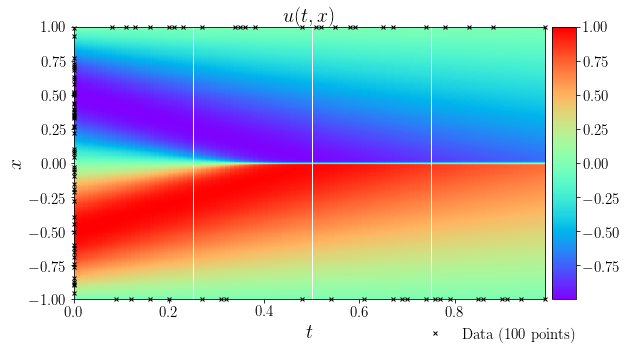

In [5]:
###### Row 0: u(t,x) ##################    

fig = plt.figure(figsize=(9, 5)) #这里figure是一个figure对象，是一个图形窗口，代表整个图形，设置图形大小为宽9英寸高5 英寸
ax = fig.add_subplot(111) #在图形的1*1网格的第一个位置添加一个子图

#绘图的数据来源
h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')   #imshow函数用于显示图像，接受一些参数，第一个参数是图像数据，这里是U_pred的转置；第二个参数是插值方法（用于在像素之间插入新的像素），这里是最邻近插值；
                                                   #第三个参数是颜色映射，这里是用彩虹色图；第四个参数是图像的范围；第五个参数是图像的原点位置，这里表示原点在右下角；第六个参数是图像的纵横比，这里表示调整横纵比以填充整个axes对象
                                                   #最后的结果返回一个axesimage对象，也就是h，可以通过这个对象进一步设置图像的属性


#添加颜色条
divider = make_axes_locatable(ax)  #使用 make_axes_locatable 函数创建了一个 AxesDivider 对象。这个函数接受一个 Axes 对象作为参数，返回一个 AxesDivider 对象。AxesDivider 对象可以用来管理子图的布局，特别是当你需要在一个图的旁边添加另一个图时。
cax = divider.append_axes("right", size="5%", pad=0.10) #使用append_axes方法在原始轴的右侧添加了一个新的轴。append_axes 方法接受三个参数：位置（"right"）、大小（"5%"）和间距（0.10）。在原始轴的右侧添加了一个新的轴，新轴的大小是原始轴的 5%，新轴与原始轴之间的间距是 0.05 英寸
   
cbar = fig.colorbar(h, cax=cax)#使用colorbar方法在新轴上添加了一个颜色条。colorbar 方法接受两个参数：axesimage 对象（h）和新轴（cax）。并记这个颜色条的名字是cbar
cbar.ax.tick_params(labelsize=15) #设置颜色条刻度标签大小，这里bar是之前定义的


#在图上绘制散点图
ax.plot(
    X_u_train[:,1], 
    X_u_train[:,0], 
    'kx', label = 'Data (%d points)' % (u_train.shape[0]), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=1.0
) #在ax上绘制散点图，前两个参数是散点的x坐标和y坐标；kx表示黑色的x（散点形状是x），label是散点的标签，clip_on表示散点可以绘制在轴的边界外
  #新加了一个alpha=1.0用来设置标记的透明度，1.0表示完全不透明  


#在图上绘制三条虚线
line = np.linspace(x.min(), x.max(), 2)[:,None]#生成了一个包含2个等间距的数值的数组，这些数值在 x.min() 到 x.max() 之间。[:,None] 是一个索引操作，用于将一维数组转换为二维数组。这里其实就是[-1;1]
#第一个参数是虚线的x坐标，line是虚线y的坐标，第三个参数是虚线的样式，w表示白色，-表示实线，最后一个参数表示虚线的参数是1
ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)    


#设置图的标签、图例、标题和刻度标签
#设置ax子图的x轴的标签为t，y轴的标签为x。这里$t$和$x$是latex格式的文本，用于生成数学公式
ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
#设置子图ax的图例，第一个参数用来设置图例的位置，这里表示图例放在上方中央;第二个参数用来设置图例的锚点，接受一个元组，表示x和y坐标，表示把图例的锚点设置在x坐标为0.9，y坐标为-0.05处;frameon=False表示不显示图例的边框;第三个参数设置图例的列数，分为5列；最后一个参数设置图例属性，接受字典，这里表示设置图例字体大小为15；最后返回的leg是一个legend对象，表示图形的图例
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
#设置子图ax的标题为$u(t,x)$，表示latex格式的文本，用于生成数学公式，fontsize=10表示字体大小为20
ax.set_title('$u(t,x)$', fontsize = 20) # font size doubled，两倍化子图标题
ax.tick_params(labelsize=15)#用来设置刻度标签的大小。`tick_params`是`Axes`对象的一个方法，可以用来设置刻度线的属性。在这里，`labelsize=15` 是用来设置刻度标签的字体大小的。


#显示图片
plt.show() #显示所有打开的图形的函数

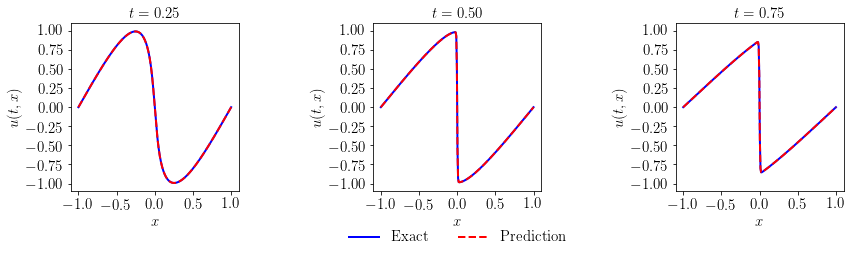

In [6]:
####### Row 1: u(t,x) slices ################## 


fig = plt.figure(figsize=(14, 10))#这里figure是一个figure对象，是一个图形窗口，代表整个图形，设置图形大小为宽14英寸高10英寸
ax = fig.add_subplot(111)#在图形的1*1网格的第一个位置添加一个子图

gs1 = gridspec.GridSpec(1, 3)#创建一个1×3的网络，用于存放子图
gs1.update(top=1-1.0/3.0-0.1, bottom=1.0-2.0/3.0, left=0.1, right=0.9, wspace=0.5)  #更新该网络的参数，第一个表示子图的顶部位置为0.567，第二个参数表示子图的底部位置为0.33，第三个表示子图左侧的位置为0.1，第四个参数表示子图的右侧位置为0.9，第五个参数表示子图之间的宽度为0.5

ax = plt.subplot(gs1[0, 0])  #在gs1[0,0]指定的位置，也就是网格的第一行第一列，创建了第一个子图，并将返回的axes对象赋值给ax。
#绘制了两条线，一条表示精确值，一条表示预测值
ax.plot(x,Exact[25,:], 'b-', linewidth = 2, label = 'Exact')   #第一个参数表示x轴上的坐标；第二个参数表示y轴上的坐标；第三个参数b-表示蓝色的实线；linewidth表示线的宽度为2；label表示线的标签，这条线表示实际值     
ax.plot(x,U_pred[25,:], 'r--', linewidth = 2, label = 'Prediction') #同上，红色虚线表示预测值
ax.set_xlabel('$x$') #设置子图的x轴的标签为x
ax.set_ylabel('$u(t,x)$')    #设置子图的y轴的标签为u(t,x)
ax.set_title('$t = 0.25$', fontsize = 15) #设置子图的标题为t=0.25，fontsize=10表示字体大小为15
ax.axis('square') #设置子图的纵横比为1，即正方形的区域
ax.set_xlim([-1.1,1.1]) #设置第一个子图的x轴的范围为[-1.1,1.1]
ax.set_ylim([-1.1,1.1]) #设置第一个子图的y轴的范围为[-1.1,1.1]
#将图形的标题、x轴标签、y轴标签以及所有的x轴和y轴的刻度标签的字体大小设置为15
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)
#循环上，`ax.title`、`ax.xaxis.label`、`ax.yaxis.label` 分别代表图形的标题、x轴标签和y轴标签。`ax.get_xticklabels()` 和 `ax.get_yticklabels()` 方法返回的是一个包含所有x轴和y轴刻度标签的列表。
#`item.set_fontsize(15)` 是用来设置列表中的元素item的字体大小的。
    
ax = plt.subplot(gs1[0, 1]) #在gs1[0,1]指定的位置，也就是网格的第一行第二列，创建了第二个子图，并将返回的axes对象赋值给ax。
ax.plot(x,Exact[50,:], 'b-', linewidth = 2, label = 'Exact')   #第一个参数表示x轴上的坐标；第二个参数表示y轴上的坐标；第三个参数b-表示蓝色的实线；linewidth表示线的宽度为2；label表示线的标签，这条线表示实际值    
ax.plot(x,U_pred[50,:], 'r--', linewidth = 2, label = 'Prediction') #同上，红色虚线表示预测值
ax.set_xlabel('$x$') #设置子图的x轴的标签为x
ax.set_ylabel('$u(t,x)$') #设置子图的y轴的标签为u(t,x)
ax.axis('square') #设置子图的纵横比为1，即正方形的区域
ax.set_xlim([-1.1,1.1]) #设置第二个子图的x轴的范围为[-1.1,1.1]
ax.set_ylim([-1.1,1.1]) #设置第二个子图的y轴的范围为[-1.1,1.1]
ax.set_title('$t = 0.50$', fontsize = 15) #设置子图的标题为t=0.50，fontsize=15表示字体大小为15
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.15), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)#设置子图的图例，loc='upper center'表示图例的位置是上方中间，bbox_to_anchor=(0.5, -0.15)表示图例的位置是在子图的中间下方0.15的位置，ncol=5表示图例的列数为5，frameon=False表示不显示图例的边框；最后一个参数设置图例属性，接受字典作为参数，这里表示将图例的字体大小设置为15
#将图形的标题、x轴标签、y轴标签以及所有的x轴和y轴的刻度标签的字体大小设置为15
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)
#循环上，`ax.title`、`ax.xaxis.label`、`ax.yaxis.label` 分别代表图形的标题、x轴标签和y轴标签。`ax.get_xticklabels()` 和 `ax.get_yticklabels()` 方法返回的是一个包含所有x轴和y轴刻度标签的列表。
#`item.set_fontsize(15)` 是用来设置列表中的元素item的字体大小的。
    
ax = plt.subplot(gs1[0, 2]) #在gs1[0,2]指定的位置，也就是网格的第一行第三列，创建了第三个子图，并将返回的axes对象赋值给ax。
ax.plot(x,Exact[75,:], 'b-', linewidth = 2, label = 'Exact')  #第一个参数表示x轴上的坐标；第二个参数表示y轴上的坐标；第三个参数b-表示蓝色的实线；linewidth表示线的宽度为2；label表示线的标签，这条线表示实际值
ax.plot(x,U_pred[75,:], 'r--', linewidth = 2, label = 'Prediction') #同上，红色虚线表示预测值
ax.set_xlabel('$x$') #设置子图的x轴的标签为x
ax.set_ylabel('$u(t,x)$') #设置子图的y轴的标签为u(t,x)
ax.axis('square') #设置子图的纵横比为1，即正方形的区域
ax.set_xlim([-1.1,1.1]) #设置第三个子图的x轴的范围为[-1.1,1.1]
ax.set_ylim([-1.1,1.1]) #设置第三个子图的y轴的范围为[-1.1,1.1]
ax.set_title('$t = 0.75$', fontsize = 15) #设置子图的标题为t=0.75，fontsize=15表示字体大小为15
#将图形的标题、x轴标签、y轴标签以及所有的x轴和y轴的刻度标签的字体大小设置为15
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)
#循环上，`ax.title`、`ax.xaxis.label`、`ax.yaxis.label` 分别代表图形的标题、x轴标签和y轴标签。`ax.get_xticklabels()` 和 `ax.get_yticklabels()` 方法返回的是一个包含所有x轴和y轴刻度标签的列表。
#`item.set_fontsize(15)` 是用来设置列表中的元素item的字体大小的。

plt.show() #显示所有打开的图形的函数